In [2]:
import h5py
import numpy as np
from scipy.fft import fft, ifft, fftfreq

ds = h5py.File('stacks_and_modeled_seismograms.h5')
list(ds['/'])

['G_HHR',
 'G_HHZ',
 'dGdt_HHR',
 'dGdt_HHZ',
 'ne_margin_HHR_stack',
 'ne_margin_HHZ_stack',
 'rift_margin_HHR_stack',
 'rift_margin_HHZ_stack',
 'rift_tip_HHR_stack',
 'rift_tip_HHZ_stack',
 'stf']

In [5]:
g = np.array(ds['/G_HHZ']).flatten()
z = np.array(ds['/ne_margin_HHZ_stack']).flatten()

In [10]:
gf = fft(g)
zf = fft(z)

answer = ifft(zf[0:1050]/gf)

/home/bpl7/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(100.0, 500.0)

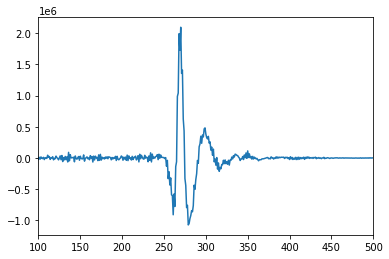

In [12]:
import matplotlib.pyplot as plt
plt.plot(answer)
plt.xlim([100, 500])

In [ ]:
# Use this for plotting:

N = len(z)
T = tr.stats.delta

yf = fft(new_tr.data)
xf = fftfreq(N, T)[:N//2]
ya = 2.0/N * np.abs(yf[0:N//2])